In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay


In [2]:
feature_cols = [
    'log_churn',
    'dmm_unit_size',
    'dmm_unit_complexity',
    'time_diff',
    'msg_len',
    'has_fix_word',
    'weekday_sin', 'weekday_cos',
    'hour_sin', 'hour_cos'
]
id_cols = ['hash', 'repo_url', 'author_date']
df = pd.read_csv('../data/data/processed/icvul_features_final.csv')
print("Shape:", df.shape)
X = df[feature_cols]
y = df['label']
print("Missing per-feature:\n", X.isna().sum())

Shape: (8690, 14)
Missing per-feature:
 log_churn              0
dmm_unit_size          0
dmm_unit_complexity    0
time_diff              0
msg_len                0
has_fix_word           0
weekday_sin            0
weekday_cos            0
hour_sin               0
hour_cos               0
dtype: int64


In [3]:
def make_stratified_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

def make_temporal_split(df, feature_cols, label_col='label', fraction_train=0.8):
    df_sorted = df.sort_values("author_date").reset_index(drop=True)
    split_idx = int(fraction_train * len(df_sorted))
    train = df_sorted.iloc[:split_idx]
    test  = df_sorted.iloc[split_idx:]
    X_tr, y_tr = train[feature_cols], train[label_col]
    X_te, y_te = test[feature_cols], test[label_col]
    return X_tr, X_te, y_tr, y_te, df_sorted

# create both splits
X_train_rand, X_test_rand, y_train_rand, y_test_rand = make_stratified_split(X, y)
X_train_temp, X_test_temp, y_train_temp, y_test_temp, df_sorted = make_temporal_split(df, feature_cols)
print("Random split sizes:", X_train_rand.shape[0], X_test_rand.shape[0])
print("Temporal split sizes:", X_train_temp.shape[0], X_test_temp.shape[0])

Random split sizes: 6952 1738
Temporal split sizes: 6952 1738


In [4]:
def evaluate_on_holdout(pipeline, X_test, y_test, name="model"):
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    print(f"\n{name} — Holdout metrics")
    print(f"ROC-AUC: {roc:.4f}   PR-AUC (AP): {pr:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    RocCurveDisplay.from_predictions(y_test, y_prob); plt.title(f"{name} — ROC"); plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues"); plt.title(f"{name} — Confusion"); plt.show()
    return {"roc_auc": roc, "pr_auc": pr, "y_prob": y_prob, "y_pred": y_pred}


Random-split evaluation (Logistic):

Logistic (Random split) — Holdout metrics
ROC-AUC: 0.8835   PR-AUC (AP): 0.9415
              precision    recall  f1-score   support

           0     0.7315    0.6906    0.7104       572
           1     0.8523    0.8756    0.8638      1166

    accuracy                         0.8147      1738
   macro avg     0.7919    0.7831    0.7871      1738
weighted avg     0.8125    0.8147    0.8133      1738



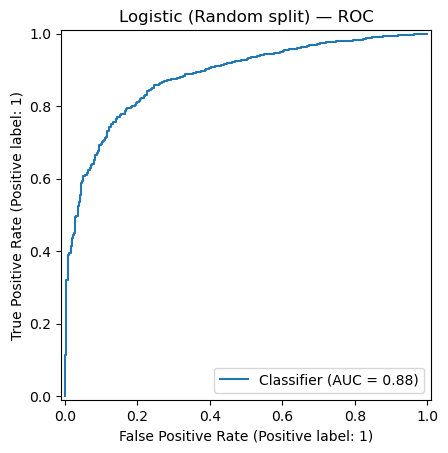

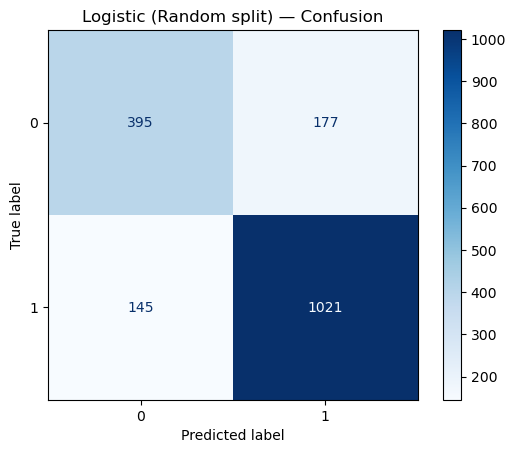

Temporal-split evaluation (Logistic):

Logistic (Temporal split) — Holdout metrics
ROC-AUC: 0.8300   PR-AUC (AP): 0.8060
              precision    recall  f1-score   support

           0     0.8639    0.5091    0.6406      1047
           1     0.5415    0.8784    0.6700       691

    accuracy                         0.6559      1738
   macro avg     0.7027    0.6938    0.6553      1738
weighted avg     0.7357    0.6559    0.6523      1738



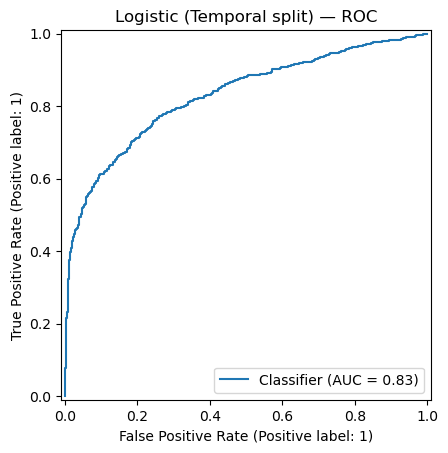

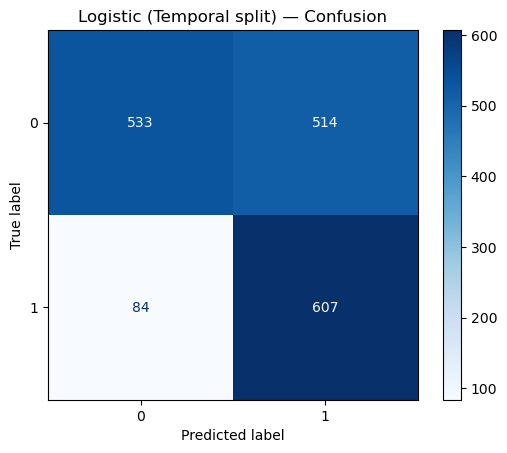

GroupKFold ROC-AUC: 0.875 ± 0.018


In [9]:
pipe_log = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, solver='lbfgs', random_state=42))
pipe_log.fit(X_train_rand, y_train_rand)
print("Random-split evaluation (Logistic):")
res_log_rand = evaluate_on_holdout(pipe_log, X_test_rand, y_test_rand, name="Logistic (Random split)")

pipe_log.fit(X_train_temp, y_train_temp)
print("Temporal-split evaluation (Logistic):")
res_log_temp = evaluate_on_holdout(pipe_log, X_test_temp, y_test_temp, name="Logistic (Temporal split)")

groups = df['repo_url']
gkf = GroupKFold(n_splits=5)
scores = cross_val_score(pipe_log, X, y, cv=gkf, groups=groups, scoring='roc_auc', n_jobs=-1)
print("GroupKFold ROC-AUC: %.3f ± %.3f" % (scores.mean(), scores.std()))

Baseline probability at feature means:  0.8839


,feature,coef_scaled,coef_orig,odds_ratio,delta_prob (+1std or 0→1)
0,log_churn,2.0286,1.9942,7.3461,0.0992
1,has_fix_word,-0.7264,-1.4550,0.2334,-0.1496
2,msg_len,-0.1094,-0.7448,0.4748,-0.0117
3,time_diff,-0.3237,-0.3717,0.6896,-0.0376
4,hour_cos,0.1207,0.1717,1.1874,0.0118
5,weekday_sin,0.0712,0.1081,1.1141,0.0071
6,weekday_cos,-0.0705,-0.0962,0.9083,-0.0074
7,hour_sin,-0.0363,-0.0590,0.9427,-0.0038
8,dmm_unit_complexity,0.0240,0.0241,1.0244,0.0024
9,dmm_unit_size,0.0079,0.0079,1.0079,0.0008


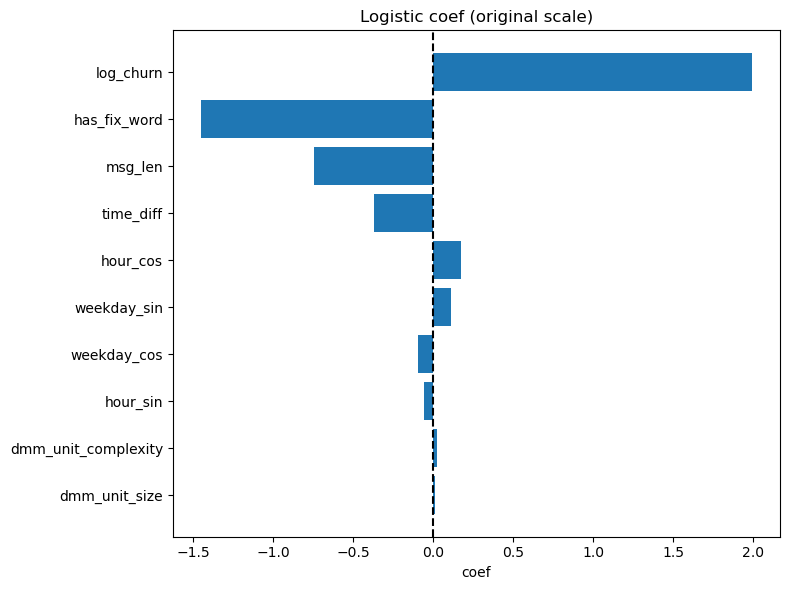

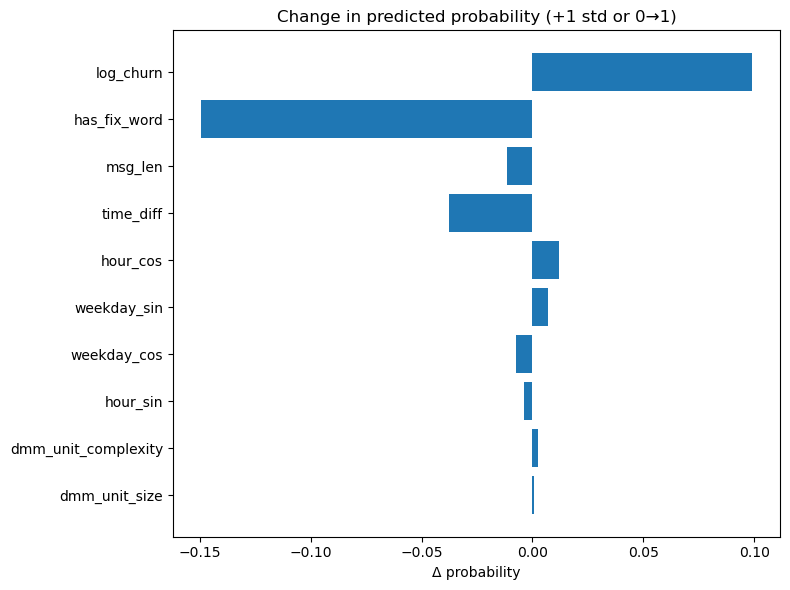

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sigmoid = lambda z: 1.0 / (1.0 + np.exp(-z))

scaler = pipe_log.named_steps["standardscaler"]
clf = pipe_log.named_steps["logisticregression"]

coef_scaled = clf.coef_.ravel()
intercept_scaled = clf.intercept_[0]

coef_orig = coef_scaled / scaler.scale_
intercept_orig = intercept_scaled - np.sum((scaler.mean_ * coef_scaled) / scaler.scale_)

feat = X.columns.tolist()
df_coef = pd.DataFrame({
    "feature": feat,
    "coef_scaled": coef_scaled,
    "coef_orig": coef_orig,
})
df_coef["odds_ratio"] = np.exp(df_coef["coef_orig"])

X_means = X_train_temp.mean()
lin_at_mean = intercept_orig + np.dot(df_coef["coef_orig"].values, X_means.values)
p_base = sigmoid(lin_at_mean)

# compute delta probability:
deltas = []
for f, c in zip(feat, df_coef["coef_orig"].values):
    if set(X_train_temp[f].unique()) <= {0, 1}:  # binary feature
        x0 = X_means.copy()
        x1 = X_means.copy()
        x0[f] = 0
        x1[f] = 1
        p0 = sigmoid(intercept_orig + np.dot(df_coef["coef_orig"].values, x0.values))
        p1 = sigmoid(intercept_orig + np.dot(df_coef["coef_orig"].values, x1.values))
        deltas.append(p1 - p0)
    else:
        # effect of +1 std
        sd = X_train_temp[f].std()
        if sd == 0:
            deltas.append(0.0)
        else:
            x0 = X_means.copy()
            x1 = X_means.copy()
            x1[f] = x1[f] + sd
            p0 = sigmoid(intercept_orig + np.dot(df_coef["coef_orig"].values, x0.values))
            p1 = sigmoid(intercept_orig + np.dot(df_coef["coef_orig"].values, x1.values))
            deltas.append(p1 - p0)

df_coef["delta_prob (+1std or 0→1)"] = deltas
df_coef = df_coef.sort_values("coef_orig", key=lambda s: np.abs(s), ascending=False)

pd.set_option("display.float_format", lambda x: f"{x:.4f}")
print("Baseline probability at feature means: ", f"{p_base:.4f}")
display(df_coef.reset_index(drop=True))

plt.figure(figsize=(8,6))
plt.barh(df_coef["feature"], df_coef["coef_orig"])
plt.axvline(0, color="k", linestyle="--")
plt.title("Logistic coef (original scale)")
plt.xlabel("coef")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.barh(df_coef["feature"], df_coef["delta_prob (+1std or 0→1)"])
plt.title("Change in predicted probability (+1 std or 0→1)")
plt.xlabel("Δ probability")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
feature_groups = {
    "all": X.columns.tolist(),
    "no_log_churn": [f for f in X.columns if f != "log_churn"],
    "no_has_fix_word": [f for f in X.columns if f != "has_fix_word"],
    "no_logchurn_fixword": [f for f in X.columns if f not in ["log_churn", "has_fix_word"]],
}

for name, cols in feature_groups.items():
    X_sub = X[cols]
    scores = cross_val_score(pipe_log, X_sub, y, cv=gkf, groups=groups, scoring='roc_auc')  # <- changed
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")


all: 0.875 ± 0.018
no_log_churn: 0.755 ± 0.025
no_has_fix_word: 0.850 ± 0.020
no_logchurn_fixword: 0.600 ± 0.022


In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, GridSearchCV, cross_val_score


In [13]:
param_dist = {
    "max_depth": [3,4,5,6,8,10,None],
    "min_samples_split": [2,5,10,20,40,80],
    "min_samples_leaf": [1,2,5,10,20,40],
    "max_features": [None, "sqrt", "log2", 0.5],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"]
}

In [15]:
def focused_grid_from_best(bp):
    raw_md = bp.get("max_depth")
    has_none = (raw_md is None)
    md_candidates_raw = {(raw_md if raw_md is not None else 5), 5}
    md_ints = sorted({int(v) for v in md_candidates_raw if v is not None and isinstance(v, (int, np.integer))})
    max_depth_vals = md_ints + ([None] if has_none else [])

    mss = int(bp.get("min_samples_split", 2))
    mss_vals = sorted({max(2, mss // 2), mss, mss * 2})

    msl = int(bp.get("min_samples_leaf", 1))
    msl_vals = sorted({max(1, msl // 2), msl, msl * 2})

    max_features_vals = list({bp.get("max_features"), None, "sqrt"})

    return {
        "max_depth": max_depth_vals,
        "min_samples_split": mss_vals,
        "min_samples_leaf": msl_vals,
        "max_features": max_features_vals,
        "criterion": [bp.get("criterion")],
        "splitter": [bp.get("splitter")]
    }

In [16]:
def tune_and_fit_dt(X_tr, y_tr, cv, groups_tr=None, n_iter=50, random_state=42):
    base = DecisionTreeClassifier(class_weight="balanced", random_state=random_state)
    rand = RandomizedSearchCV(base, param_distributions=param_dist, n_iter=n_iter,
                              scoring="roc_auc", cv=cv, n_jobs=-1, random_state=random_state, verbose=1, refit=True)
    if groups_tr is None:
        rand.fit(X_tr, y_tr)
    else:
        rand.fit(X_tr, y_tr, groups=groups_tr)

    bp = rand.best_params_
    grid_params = focused_grid_from_best(bp)
    grid = GridSearchCV(DecisionTreeClassifier(class_weight="balanced", random_state=random_state),
                        param_grid=grid_params, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1, refit=True)
    if groups_tr is None:
        grid.fit(X_tr, y_tr)
    else:
        grid.fit(X_tr, y_tr, groups=groups_tr)

    return rand, grid

In [17]:
def evaluate_model(est, X_test, y_test, name="model"):
    y_prob = est.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_test, y_prob)
    print(f"\n{name} — Test ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{name} — ROC"); plt.show()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f"{name} — Confusion"); plt.show()
    return {"auc": auc, "y_prob": y_prob, "y_pred": y_pred}

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/tolgakuntman/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_split.py:883: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Random-split best CV AUC (grid): 0.8731478988918804

DecisionTree (Random split) — Test ROC-AUC: 0.8829
              precision    recall  f1-score   support

           0     0.6896    0.8234    0.7506       572
           1     0.9043    0.8182    0.8591      1166

    accuracy                         0.8199      1738
   macro avg     0.7969    0.8208    0.8048      1738
weighted avg     0.8336    0.8199    0.8234      1738



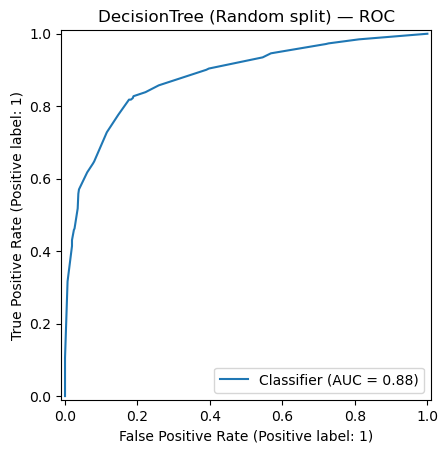

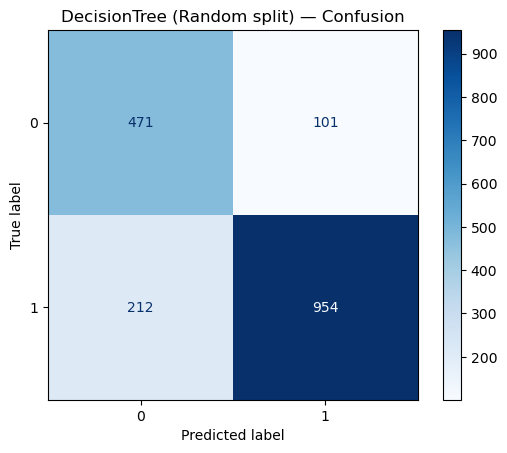

Temporal-split best CV AUC (grid): 0.8806349356092905

DecisionTree (Temporal split) — Test ROC-AUC: 0.8226
              precision    recall  f1-score   support

           0     0.7970    0.8214    0.8090      1047
           1     0.7162    0.6831    0.6993       691

    accuracy                         0.7664      1738
   macro avg     0.7566    0.7522    0.7541      1738
weighted avg     0.7649    0.7664    0.7654      1738



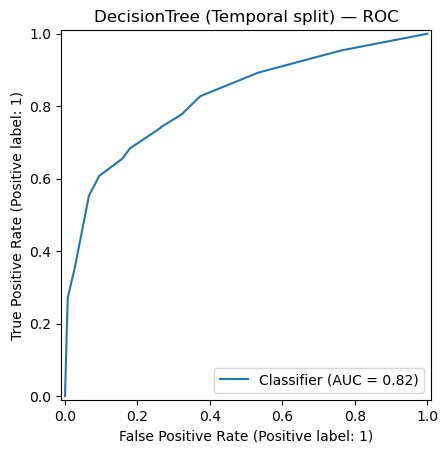

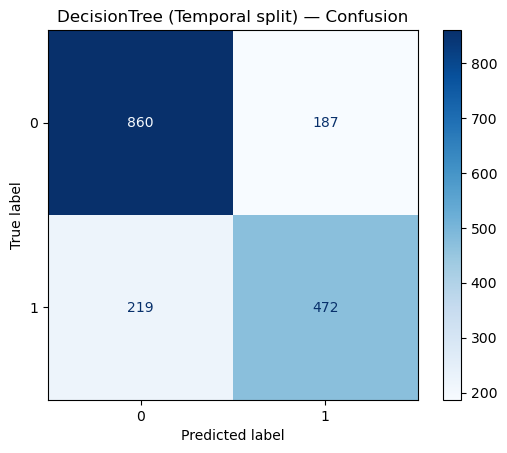


Summary comparison:


,split,cv_auc,test_auc,best_params
0,random,0.8731,0.8829,"{'criterion': 'gini', 'max_depth': 5, 'max_fea..."
1,temporal,0.8806,0.8226,"{'criterion': 'gini', 'max_depth': 4, 'max_fea..."


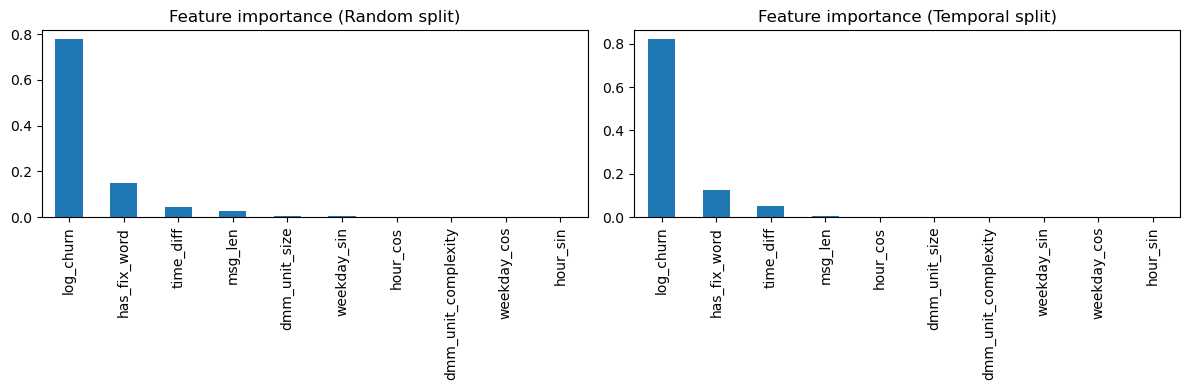

In [18]:
rand_rand, grid_rand = tune_and_fit_dt(X_train_rand, y_train_rand, cv=5, groups_tr=df.loc[y_train_rand.index, 'repo_url'])
best_rand = grid_rand.best_estimator_
rand_temp, grid_temp = tune_and_fit_dt(X_train_temp, y_train_temp, cv=5, groups_tr=df.loc[y_train_temp.index, 'repo_url'])
best_temp = grid_temp.best_estimator_
print("Random-split best CV AUC (grid):", grid_rand.best_score_)
res_rand = evaluate_model(best_rand, X_test_rand, y_test_rand, name="DecisionTree (Random split)")
print("Temporal-split best CV AUC (grid):", grid_temp.best_score_)
res_temp = evaluate_model(best_temp, X_test_temp, y_test_temp, name="DecisionTree (Temporal split)")
summary = pd.DataFrame([
    {"split": "random", "cv_auc": grid_rand.best_score_, "test_auc": res_rand["auc"], "best_params": grid_rand.best_params_},
    {"split": "temporal", "cv_auc": grid_temp.best_score_, "test_auc": res_temp["auc"], "best_params": grid_temp.best_params_}
])
print("\nSummary comparison:")
display(summary)

fi_rand = pd.Series(best_rand.feature_importances_, index=X.columns).sort_values(ascending=False)
fi_temp = pd.Series(best_temp.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); fi_rand.plot.bar(title="Feature importance (Random split)")
plt.subplot(1,2,2); fi_temp.plot.bar(title="Feature importance (Temporal split)")
plt.tight_layout(); plt.show()

In [19]:
groups = df["repo_url"]
gkf = GroupKFold(n_splits=5)

scores_best_rand = cross_val_score(best_rand, X, y, cv=gkf, groups=groups, scoring='roc_auc', n_jobs=-1)
scores_best_temp = cross_val_score(best_temp, X, y, cv=gkf, groups=groups, scoring='roc_auc', n_jobs=-1)

print(f"Best (random-split) GroupKFold ROC-AUC: {scores_best_rand.mean():.3f} ± {scores_best_rand.std():.3f}")
print(f"Best (temporal-split) GroupKFold ROC-AUC: {scores_best_temp.mean():.3f} ± {scores_best_temp.std():.3f}")

try:
    summary.loc[summary['split']=='random', 'group_cv_auc'] = scores_best_rand.mean()
    summary.loc[summary['split']=='temporal', 'group_cv_auc'] = scores_best_temp.mean()
    print("\nUpdated summary:")
    display(summary)
except NameError:
    pass

Best (random-split) GroupKFold ROC-AUC: 0.864 ± 0.015
Best (temporal-split) GroupKFold ROC-AUC: 0.867 ± 0.014

Updated summary:


,split,cv_auc,test_auc,best_params,group_cv_auc
0,random,0.8731,0.8829,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.8640
1,temporal,0.8806,0.8226,"{'criterion': 'gini', 'max_depth': 4, 'max_fea...",0.8666
